In [1]:
import torch
import math

from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue      
size=1000;
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable((train_classes))
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)
mini_batch_size = 10


C:\Users\antho\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\antho\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\antho\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\antho\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [2]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

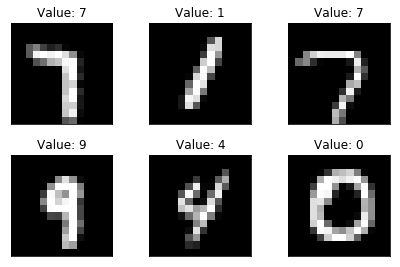

In [3]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][1], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][1]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

# First neural net
Train the model on all the 2000 images in train_input

In [4]:
my_train_input1 = train_input[:,0,:]
my_train_input2 = train_input[:,1,:]
my_train_classes1 = train_classes[0:1000,0]
my_train_classes2 = train_classes[0:1000,1]

my_test_input1 = test_input[:,0,:]
my_test_input2 = test_input[:,1,:]
my_test_classes1 = test_classes[0:1000,0]
my_test_classes2 = test_classes[0:1000,1]

In [5]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of epoch
num_epochs = 25
# batch size to compute mini-batch
batch_size = 2
# number of pixels in the image 
input_size = 20
# number of possible digit: 0 to 9 
num_class = 2
# small step to find a minima
learning_rate = 0.001
# hidden size
hidden_size = 1000

In [36]:
def test_accuracy(model_, my_test_input1_, my_test_input2_, test_target_, batch_size_):
    total = 0
    well_predicted_count = 0
    for i in range(int(len(my_test_input1_)/batch_size_)):
        images1 = my_test_input1_.narrow(0,i*batch_size_,batch_size_).to(device)
        images2 = my_test_input2_.narrow(0,i*batch_size_,batch_size_).to(device)
        labels = test_target_.narrow(0,i*batch_size_,batch_size_).to(device)
        total += labels.size(0)
        out1, out2, result = model_(images1, images2, batch_size_)
        
        t = Variable(torch.Tensor([0.5]))
        predictions = (result > t).float() * 1
        predictions = predictions.reshape(1000)
        
        well_predicted_count += (predictions.long() == labels).sum().item()

    return 1 - well_predicted_count / total

In [37]:
import datetime
import time

def train_model(model_, my_train_input1_, my_train_input2_, my_test_classes1, my_test_classes2, train_target_, criterion_, optimizer_,num_epochs_,batch_size_):

    train_error = []
    test_error = []
    # train function
    for epoch in range(1, num_epochs_+1):
        for i in range(int(len(my_train_input1_)/batch_size_)):  
            # Move tensors to the configured device
            images1 = my_train_input1_.narrow(0,i*batch_size_,batch_size_).to(device)
            images2 = my_train_input2_.narrow(0,i*batch_size_,batch_size_).to(device)
            labels1 = my_test_classes1.narrow(0,i*batch_size_,batch_size_).to(device)
            labels2 = my_test_classes2.narrow(0,i*batch_size_,batch_size_).to(device)
            target_labels = train_target_.narrow(0,i*batch_size_,batch_size_).to(device)
            
            # Forward pass
            out1, out2, result = model_(images1, images2, batch_size_)
            #result.requires_grad=True
            loss1 = criterion_(out1, labels1)
            loss2 = criterion_(out2, labels2)
            
            """_, predictions1 = torch.max(out1.data, 1)
            _, predictions2 = torch.max(out2.data, 1)
            predictions = (predictions1 >= predictions2).long()"""

            criterion3 = nn.MSELoss()
            loss3 = criterion3(result, train_target_.float())
            real_loss = loss1 + loss2 + loss3

            # Backward and optimize
            optimizer_.zero_grad()
            real_loss.backward()
            optimizer_.step()            


        train_error.append(test_accuracy(model_, my_train_input1_, my_train_input2_, train_target,1000))
        test_error.append(test_accuracy(model_, my_test_input1, my_test_input2, test_target,1000))
        if(epoch % 5 == 0 or epoch == 1):    
            print ('Loss: {:.4f} on epoch: {}, train error: {}, test error: {}'.format(real_loss.item(),epoch,train_error[-1],test_error[-1]))
    return train_error, test_error

In [38]:
#as we got 100% on the train error it seems that we just leared by heart the train dataset
# let's adding regularization:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(64, 25)
        self.fc2 = nn.Linear(25, 10)
        
        self.layer1_comp = nn.Linear(input_size, 30)
        self.relu = nn.Softmax()
        self.layer2_comp = nn.Linear(30, 1)
    
    def forward(self, img1, img2, batch_size_images):
        img1 = img1.reshape(batch_size_images,1,14,14)
        out1 = self.layer1(img1)        
        out1 = self.layer2(out1)
        out1 = out1.reshape(out1.size(0), -1)
        out1 = self.drop_out(out1)
        out1 = self.fc1(out1)
        out1 = self.fc2(out1)
        
        img2 = img2.reshape(batch_size_images,1,14,14)
        out2 = self.layer1(img2)        
        out2 = self.layer2(out2)
        out2 = out2.reshape(out2.size(0), -1)
        out2 = self.drop_out(out2)
        out2 = self.fc1(out2)
        out2 = self.fc2(out2)

        result = torch.cat((out1, out2),1)

        result = self.layer1_comp(result)
        result = self.relu(result)
        result = self.layer2_comp(result)
        return out1, out2, result
  
# creating neural net
model = NeuralNet(input_size, hidden_size, num_class).to(device)

# CrossEntropyLoss and optimizer which minimize loss with learning rate step
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

train_error, test_error = train_model(model, my_train_input1, my_train_input2, my_train_classes1, my_train_classes2, train_target, criterion, optimizer, num_epochs, 1)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss: 0.2634 on epoch: 1, train error: 0.5740000000000001, test error: 0.5569999999999999
Loss: 0.4072 on epoch: 5, train error: 0.493, test error: 0.497
Loss: 0.2497 on epoch: 10, train error: 0.501, test error: 0.52
Loss: 0.3868 on epoch: 15, train error: 0.477, test error: 0.5
Loss: 0.2592 on epoch: 20, train error: 0.472, test error: 0.46799999999999997


KeyboardInterrupt: 

In [ ]:
plt.plot(train_error, 'r--', test_error, 'b--')
plt.ylabel('some numbers')
plt.title("Train error in red, test error in blue over the epoch")
plt.show()

In [ ]:
train_error

In [ ]:
print("Accuracy: {}".format(1-min(test_error)))